In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
path = Path('data')
df = pd.read_csv(path/"train.csv")
df_test = pd.read_csv(path/'test.csv')

In [4]:
df.head()

,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,1049524,3953454613,s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_00.tif,s3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_00.tif,s3://drivendata-competition-biomassters-public-as/train_features/0003d2eb_S1_00.tif,0003d2eb_agbm.tif
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,1049524,3531005382,s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_01.tif,s3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_01.tif,s3://drivendata-competition-biomassters-public-as/train_features/0003d2eb_S1_01.tif,0003d2eb_agbm.tif
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,1049524,1401197002,s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_02.tif,s3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_02.tif,s3://drivendata-competition-biomassters-public-as/train_features/0003d2eb_S1_02.tif,0003d2eb_agbm.tif
3,0003d2eb_S1_03.tif,0003d2eb,S1,train,December,1049524,3253084255,s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_03.tif,s3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_03.tif,s3://drivendata-competition-biomassters-public-as/train_features/0003d2eb_S1_03.tif,0003d2eb_agbm.tif
4,0003d2eb_S1_04.tif,0003d2eb,S1,train,January,1049524,2467836265,s3://drivendata-competition-biomassters-public-us/train_features/0003d2eb_S1_04.tif,s3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_04.tif,s3://drivendata-competition-biomassters-public-as/train_features/0003d2eb_S1_04.tif,0003d2eb_agbm.tif


In [5]:
chip_ids_train = df['chip_id'].unique()
chip_ids_test = df_test['chip_id'].unique()
len(chip_ids_train), len(chip_ids_test)

(11462, 8689)

In [6]:
months = df["month"].unique()
months

array(['September', 'October', 'November', 'December', 'January',
       'February', 'March', 'April', 'May', 'June', 'July', 'August'],
      dtype=object)

In [7]:
month_ids = df.filename.apply(lambda x: x.split('_')[-1].split('.')[0]).unique()
month_ids

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11'], dtype=object)

In [8]:
sensors = df['satellite'].unique()
sensors

array(['S1', 'S2'], dtype=object)

In [13]:
def generate_df(chip_ids, features, add_label=True):
    filenames, labels  = [], []
    for chip_id in tqdm(chip_ids):
        names = {'S1': {}, 'S2': {}}
        for sensor in sensors:
            for month, month_id in zip(months, month_ids):
                filepath = f'{chip_id}_{sensor}_{month_id}.tif'
                if (path/'train_features'/filepath).exists():
                    names[sensor][month] = str(path/features/filepath) 
                else:
                    names[sensor][month] = None
        filenames.append(names)
        label_filename = f'{chip_id}_agbm.tif'
        if add_label:
            if (path/'train_agbm'/label_filename).exists():
                labels.append(f'{str(path)}/train_agbm/{label_filename}')
            else:
                labels.append(None)
    if add_label:
        return pd.DataFrame({'filename': filenames, 'label': labels}, index=chip_ids)
    return pd.DataFrame({'filename': filenames}, index=chip_ids)

In [14]:
train_df = generate_df(chip_ids_train, 'train_features')
test_df = generate_df(chip_ids_test, 'test_features', False)

100%|██████████| 8689/8689 [11:43<00:00, 12.35it/s]  


In [33]:
train_df.shape

(11462, 2)

In [34]:
train_df.dropna().shape

(8689, 2)

In [35]:
train_df.dropna().to_json(path/'train_clean.json')
test_df.dropna().to_json(path/'test_clean.json')

In [36]:
train_df = pd.read_json(path/'train_clean.json')
test_df = pd.read_json(path/'test_clean.json')

In [37]:
train_df.head()

,filename,label
0003d2eb,"{'S1': {'September': 'data/train_features/0003d2eb_S1_00.tif', 'October': 'data/train_features/0003d2eb_S1_01.tif', 'November': 'data/train_features/0003d2eb_S1_02.tif', 'December': 'data/train_features/0003d2eb_S1_03.tif', 'January': 'data/train_features/0003d2eb_S1_04.tif', 'February': 'data/train_features/0003d2eb_S1_05.tif', 'March': 'data/train_features/0003d2eb_S1_06.tif', 'April': 'data/train_features/0003d2eb_S1_07.tif', 'May': 'data/train_features/0003d2eb_S1_08.tif', 'June': 'data/train_features/0003d2eb_S1_09.tif', 'July': 'data/train_features/0003d2eb_S1_10.tif', 'August': 'data/train_features/0003d2eb_S1_11.tif'}, 'S2': {'September': 'data/train_features/0003d2eb_S2_00.tif', 'October': 'data/train_features/0003d2eb_S2_01.tif', 'November': None, 'December': None, 'January': None, 'February': 'data/train_features/0003d2eb_S2_05.tif', 'March': 'data/train_features/0003d2eb_S2_06.tif', 'April': 'data/train_features/0003d2eb_S2_07.tif', 'May': 'data/train_features/0003d2eb_S2_08.tif', 'June': 'data/train_features/0003d2eb_S2_09.tif', 'July': 'data/train_features/0003d2eb_S2_10.tif', 'August': 'data/train_features/0003d2eb_S2_11.tif'}}",data/train_agbm/0003d2eb_agbm.tif
000aa810,"{'S1': {'September': 'data/train_features/000aa810_S1_00.tif', 'October': 'data/train_features/000aa810_S1_01.tif', 'November': 'data/train_features/000aa810_S1_02.tif', 'December': 'data/train_features/000aa810_S1_03.tif', 'January': 'data/train_features/000aa810_S1_04.tif', 'February': 'data/train_features/000aa810_S1_05.tif', 'March': 'data/train_features/000aa810_S1_06.tif', 'April': 'data/train_features/000aa810_S1_07.tif', 'May': 'data/train_features/000aa810_S1_08.tif', 'June': 'data/train_features/000aa810_S1_09.tif', 'July': 'data/train_features/000aa810_S1_10.tif', 'August': 'data/train_features/000aa810_S1_11.tif'}, 'S2': {'September': None, 'October': None, 'November': None, 'December': None, 'January': None, 'February': None, 'March': 'data/train_features/000aa810_S2_06.tif', 'April': 'data/train_features/000aa810_S2_07.tif', 'May': 'data/train_features/000aa810_S2_08.tif', 'June': 'data/train_features/000aa810_S2_09.tif', 'July': 'data/train_features/000aa810_S2_10.tif', 'August': 'data/train_features/000aa810_S2_11.tif'}}",data/train_agbm/000aa810_agbm.tif
000d7e33,"{'S1': {'September': 'data/train_features/000d7e33_S1_00.tif', 'October': 'data/train_features/000d7e33_S1_01.tif', 'November': 'data/train_features/000d7e33_S1_02.tif', 'December': 'data/train_features/000d7e33_S1_03.tif', 'January': 'data/train_features/000d7e33_S1_04.tif', 'February': 'data/train_features/000d7e33_S1_05.tif', 'March': 'data/train_features/000d7e33_S1_06.tif', 'April': 'data/train_features/000d7e33_S1_07.tif', 'May': 'data/train_features/000d7e33_S1_08.tif', 'June': 'data/train_features/000d7e33_S1_09.tif', 'July': 'data/train_features/000d7e33_S1_10.tif', 'August': 'data/train_features/000d7e33_S1_11.tif'}, 'S2': {'September': None, 'October': None, 'November': None, 'December': None, 'January': None, 'February': None, 'March': 'data/train_features/000d7e33_S2_06.tif', 'April': 'data/train_features/000d7e33_S2_07.tif', 'May': 'data/train_features/000d7e33_S2_08.tif', 'June': 'data/train_features/000d7e33_S2_09.tif', 'July': 'data/train_features/000d7e33_S2_10.tif', 'August': 'data/train_features/000d7e33_S2_11.tif'}}",data/train_agbm/000d7e33_agbm.tif
00184691,"{'S1': {'September': 'data/train_features/00184691_S1_00.tif', 'October': 'data/train_features/00184691_S1_01.tif', 'November': 'data/train_features/00184691_S1_02.tif', 'December': 'data/train_features/00184691_S1_03.tif', 'January': 'data/train_features/00184691_S1_04.tif', 'February': 'data/train_features/00184691_S1_05.tif', 'March': 'data/train_features/00184691_S1_06.tif', 'April': 'data/train_features/00184691_S1_07.tif', 'May': 'data/train_features/00184691_S1_08.tif', 'June': 'data/train_features/00184691_S1_09.tif', 'July': 'data/train_features/00184691_S1

In [38]:
test_df.head()

,filename
0003d2eb,"{'S1': {'September': 'data/test_features/0003d2eb_S1_00.tif', 'October': 'data/test_features/0003d2eb_S1_01.tif', 'November': 'data/test_features/0003d2eb_S1_02.tif', 'December': 'data/test_features/0003d2eb_S1_03.tif', 'January': 'data/test_features/0003d2eb_S1_04.tif', 'February': 'data/test_features/0003d2eb_S1_05.tif', 'March': 'data/test_features/0003d2eb_S1_06.tif', 'April': 'data/test_features/0003d2eb_S1_07.tif', 'May': 'data/test_features/0003d2eb_S1_08.tif', 'June': 'data/test_features/0003d2eb_S1_09.tif', 'July': 'data/test_features/0003d2eb_S1_10.tif', 'August': 'data/test_features/0003d2eb_S1_11.tif'}, 'S2': {'September': 'data/test_features/0003d2eb_S2_00.tif', 'October': 'data/test_features/0003d2eb_S2_01.tif', 'November': None, 'December': None, 'January': None, 'February': 'data/test_features/0003d2eb_S2_05.tif', 'March': 'data/test_features/0003d2eb_S2_06.tif', 'April': 'data/test_features/0003d2eb_S2_07.tif', 'May': 'data/test_features/0003d2eb_S2_08.tif', 'June': 'data/test_features/0003d2eb_S2_09.tif', 'July': 'data/test_features/0003d2eb_S2_10.tif', 'August': 'data/test_features/0003d2eb_S2_11.tif'}}"
000aa810,"{'S1': {'September': 'data/test_features/000aa810_S1_00.tif', 'October': 'data/test_features/000aa810_S1_01.tif', 'November': 'data/test_features/000aa810_S1_02.tif', 'December': 'data/test_features/000aa810_S1_03.tif', 'January': 'data/test_features/000aa810_S1_04.tif', 'February': 'data/test_features/000aa810_S1_05.tif', 'March': 'data/test_features/000aa810_S1_06.tif', 'April': 'data/test_features/000aa810_S1_07.tif', 'May': 'data/test_features/000aa810_S1_08.tif', 'June': 'data/test_features/000aa810_S1_09.tif', 'July': 'data/test_features/000aa810_S1_10.tif', 'August': 'data/test_features/000aa810_S1_11.tif'}, 'S2': {'September': None, 'October': None, 'November': None, 'December': None, 'January': None, 'February': None, 'March': 'data/test_features/000aa810_S2_06.tif', 'April': 'data/test_features/000aa810_S2_07.tif', 'May': 'data/test_features/000aa810_S2_08.tif', 'June': 'data/test_features/000aa810_S2_09.tif', 'July': 'data/test_features/000aa810_S2_10.tif', 'August': 'data/test_features/000aa810_S2_11.tif'}}"
000d7e33,"{'S1': {'September': 'data/test_features/000d7e33_S1_00.tif', 'October': 'data/test_features/000d7e33_S1_01.tif', 'November': 'data/test_features/000d7e33_S1_02.tif', 'December': 'data/test_features/000d7e33_S1_03.tif', 'January': 'data/test_features/000d7e33_S1_04.tif', 'February': 'data/test_features/000d7e33_S1_05.tif', 'March': 'data/test_features/000d7e33_S1_06.tif', 'April': 'data/test_features/000d7e33_S1_07.tif', 'May': 'data/test_features/000d7e33_S1_08.tif', 'June': 'data/test_features/000d7e33_S1_09.tif', 'July': 'data/test_features/000d7e33_S1_10.tif', 'August': 'data/test_features/000d7e33_S1_11.tif'}, 'S2': {'September': None, 'October': None, 'November': None, 'December': None, 'January': None, 'February': None, 'March': 'data/test_features/000d7e33_S2_06.tif', 'April': 'data/test_features/000d7e33_S2_07.tif', 'May': 'data/test_features/000d7e33_S2_08.tif', 'June': 'data/test_features/000d7e33_S2_09.tif', 'July': 'data/test_features/000d7e33_S2_10.tif', 'August': 'data/test_features/000d7e33_S2_11.tif'}}"
00184691,"{'S1': {'September': 'data/test_features/00184691_S1_00.tif', 'October': 'data/test_features/00184691_S1_01.tif', 'November': 'data/test_features/00184691_S1_02.tif', 'December': 'data/test_features/00184691_S1_03.tif', 'January': 'data/test_features/00184691_S1_04.tif', 'February': 'data/test_features/00184691_S1_05.tif', 'March': 'data/test_features/00184691_S1_06.tif', 'April': 'data/test_features/00184691_S1_07.tif', 'May': 'data/test_features/00184691_S1_08.tif', 'June': 'data/test_features/00184691_S1_09.tif', 'July': 'data/test_features/00184691_S1_10.tif', 'August': 'data/test_features/00184691_S1_11.tif'}, 'S2': {'September': None, 'October': None, 'November': None, 'December': None, 'January': None, 'February': None, 

In [39]:
sample = train_df.iloc[0]
s1 = sample.filename['S1']['September']
s2 = sample.filename['S2']['September']
label = sample.label
s1, s2, label

('data/train_features/0003d2eb_S1_00.tif',
 'data/train_features/0003d2eb_S2_00.tif',
 'data/train_agbm/0003d2eb_agbm.tif')

In [40]:
ds = rio.open(s1)
ds.indexes

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(1, 2, 3, 4)

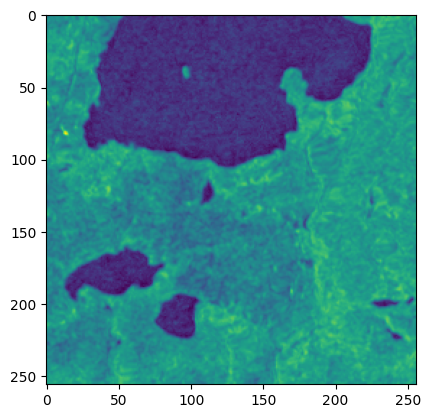

In [41]:
x = ds.read(1)
plt.imshow(x)
plt.show()

In [42]:
x.shape, x.min(), x.max(), x.dtype

((256, 256), -22.103586, -3.264444, dtype('float32'))

In [43]:
ds = rio.open(s2)
ds.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)

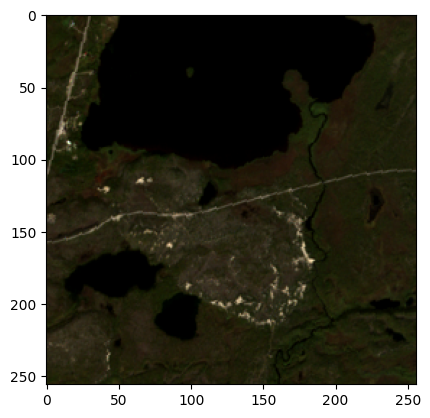

In [44]:
r, g, b = ds.read(3), ds.read(2), ds.read(1)
rgb = np.dstack((r, g, b))
rgb = np.clip(rgb / 3000, 0, 1)

plt.imshow(rgb)
plt.show()

In [45]:
rgb.dtype, rgb.shape, rgb.min(), rgb.max()

(dtype('float64'), (256, 256, 3), 0.0003333333333333333, 1.0)

In [46]:
ds = rio.open(label)
ds.indexes

(1,)

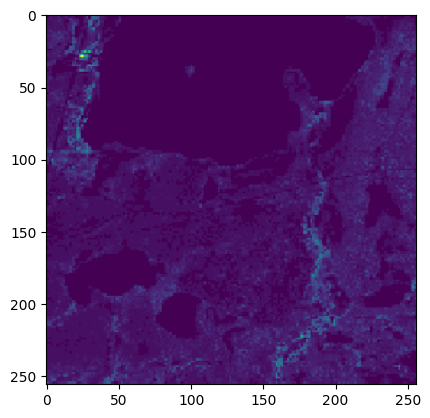

In [47]:
y = ds.read(1)

plt.imshow(y)
plt.show()

In [48]:
y.dtype, y.shape, y.min(), y.max()

(dtype('float32'), (256, 256), 0.0, 130.34)

In [49]:
maxs, mins, means, stds = [], [], [], []
for chip_id, row in tqdm(train_df.iterrows()):
    if Path(row.label).exists():
        ds = rio.open(row.label)
        y = ds.read(1)
        maxs.append(y.max())
        mins.append(y.min())
        means.append(y.mean())
        stds.append(y.std())

8689it [08:29, 17.05it/s]


In [50]:
np.max(maxs), np.min(mins), np.mean(means), np.std(stds)

(12905.3, 0.0, 63.32611, 21.467716)